# SciPy Optimize Basin Hopping
<hr />

Basin hopping is a Monte Carlo algorithm motivated based on physics.  A <b>Monte Carlo</b> algorithm is one that uses random numbers.  The standard version of the algorithm is a <b>Markov Chain</b>.  Markov Chain's are a random walk, composed of a series of locations that only depend on the previous step.   

The routine has a three step process:
1. [Randomly create a new coordinate](#new)
2. [Perform a local minimization](#local)
3. [Decide whether or not to accept the new minimum](#accept)
    
![graphics of the process](./images/basin_hopping2.svg)

This method of global optimization can work in an arbitrarily large dimensional problem space, can overcome large energy barriers between local minima, and can store all found local minima.  But the algorithm can still get stuck in an area if the entire domain is large and filled with many local minima.  This also routine takes requires customization and tuning.  That customization and tuning makes the algorithm more difficult straight out of the box, but can make this option much more favorable when you want that control.
    
So let's get started with the tutorial by importing packages:

In [2]:
# Importing the packages for the example
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

And defining a simple test function:

In [3]:
f = lambda x : 1/50*(x[0]**2 + x[1]**2) - np.cos(x[0])*np.cos(x[1])

df = lambda x : np.array([1/25*x[0]+np.sin(x[0])*np.cos(x[1]),
                          1/25*x[1]+np.cos(x[0])*np.sin(x[1])])

f_parameter = lambda x, a : 1/50*(x[0]**2 + x[1]**2) - np.cos(x[0]-a)*np.cos(x[1])

Now that we've defined this function, what does it look like?

No handles with labels found to put in legend.


Text(0, 0.5, 'x[1]')

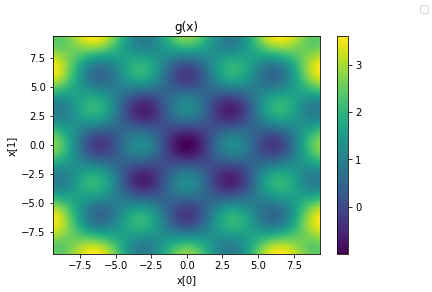

In [4]:
x0=np.arange(-3*np.pi,3*np.pi,.05)

x0_a, x1_a = np.meshgrid(x0,x0)

# plotting our test functions
fig, ax = plt.subplots()
pos = ax.pcolormesh(x0_a,x1_a,f([x0_a,x1_a]) )

# labeling and measuring necessities
fig.legend()
fig.colorbar(pos,ax=ax)
ax.set_title('g(x)')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')

<div id="basic" />

## Basic Call
<hr>

Basin hopping is highly configurable.  Each of the steps can be both tuned by parameters or completely overriden by new functions.  The un-tuned minimization has a low chance of working.  Even with the simple tutorial function, this routine will fail to find the global minimum without help:

In [5]:
starting_point=[3*np.pi,3*np.pi]
result_bad=optimize.basinhopping(f,starting_point)
result_bad.x

array([9.02162856, 9.0216285 ])

<div id="new" />

## 1. Choosing a new coordinate
<hr>

In step 1, the routine has to generate new coordinates.  The default settings pick a displacement from a uniform probability distribution function ranging from -stepsize to +stepsize:

$$ 
   x_{i+1} = x_i + \delta  \qquad \delta \in [-\text{stepsize},\text{stepsize}]
$$
    
The greatest efficiency comes when the stepsize is approximately the distance between adjacent minima.  Since the local minima in our function are generate by $\cos(x)$, the period is $2 \pi$.  Simply setting our stepsize to that number allows the routine to converge to the global minimum:

In [6]:
result_ss=optimize.basinhopping(f,starting_point,stepsize=2*np.pi)
result_ss.x

array([-1.10555048e-07,  2.31265321e-07])

The routine also has the ability to automatically determine the best stepsize itself.  If we didn't know ahead of time the periodicity of our function, or the periodicity changed throughout space we can set the `interval` to some number:

In [7]:
result_updatess=optimize.basinhopping(f,starting_point,interval=5)
result_updatess.x

array([-1.45198607e-08, -9.22203516e-09])

<div id="step-function" />

#### Custom step taking function

`stepsize` and `interval` just tune parameters for the provided function.  We can provide an entirely new protocol for generating the new coordinates as well.  

We just need a function that takes in and returns a set of coordinates.  We can generate the function the standard way, or we can create the function as an instance of a class.  If it's an instance of a class, it can also have the `stepsize` attribute.  Only this way can `basinhopping` adapt the stepsize over time:

So how does this work? Here I define a class that pulls from a Gaussian, also known as normal, distribution instead.  We define a `__init__` and `__call__` components and set up the stepsize.

In [13]:
class Take_Step_Class(object):
    def __init__(self, stepsize=1):
        self.stepsize = stepsize
    def __call__(self,x):
        x += self.stepsize * np.random.standard_normal(x.shape)
        return x

Now we can initialize this class:

In [14]:
take_step_object = Take_Step_Class(stepsize=2*np.pi)

And now verify that it does indeed have the stepsize component:

In [15]:
take_step_object.stepsize

6.283185307179586

And we can use it a function as well to generate the next set of coordinates:

In [16]:
xk = np.array([0.,0.]) # current coordinates

take_step_object(xk)

array([ 0.91448325, -3.1649184 ])

After all that work, we pass the object/ function to `basinhopping` via the `take_step` flag:

In [17]:
result_takestep = optimize.basinhopping(f,starting_point,take_step=take_step_object)
result_takestep.x

array([-4.08966585e-09, -6.74575310e-09])

<div id="local" />

## 2. Local Minimization
<hr>

After generating a new set of coordinates, the routine performs a local minimization starting at that point.  This step is less critical to the overall success of the global minimization process, but does affect the over speed an efficiency of the process.  

This process uses `scipy.optimize.minimize`, so check [that tutorial](./Optimization_ND.ipynb) for more information.  We can send information to `minimize` in a dictionary:

In [18]:
minimizer_kwargs_dict = {"method":"BFGS",
                         "jac":df}

In [19]:
result_local = optimize.basinhopping(f,starting_point,stepsize=2*np.pi,
                      minimizer_kwargs=minimizer_kwargs_dict)
result_local.x

array([ 3.18140468e-09, -2.36517918e-09])

<div id="accept" />

## 3. Accepting a New Coordinate
<hr>

The standard algorithm accepts a new minimum according to the <b>Metropolis-Hastings</b> criterion.  

In the Metropolis-Hastings criteria, the probability of accepting a new value $f_{i+1}$ with an old value $f_{i}$

$$
P(\text{accept}) = \text{min} \big\{ e^{\frac{f_{i+1}-f_i}{T}} , 1 \big\}
$$

Just like we created a [custom step taking function](#step-function), we can create a custom function to accept a new minima. 

The function recieves `x_new`,`x_old`,`f_new`, and `f_old` in a dictionary form.  The function does not recieve temperature `T` or any other parameters.  By making a class function, we can incorporate the temperature or store any other type of necessary data for the evaluation.

Here, I will define a create a custom minimizer to create a <b>Simulated Annealing</b> simulation.  In Simulated Annealing, the temperature decreases over time.  In the beginning of the simulation, the algorithm is free to bounce around and explore even unfavorable areas; only later does the simulation settle down toward the lowest possible energies

In [48]:
class MyBounds(object):
    def __init__(self, T0 = 10 ):
        self.T = T0
    def __call__(self, **kwargs):
        
        #this is the Simulated Annealing part
        self.T = .8* self.T;

        if kwargs["f_new"]<kwargs["f_old"]:
            # if the new minimum is lower, we accept it
            return True
        elif np.random.rand() < np.exp( (kwargs["f_old"]-kwargs["f_new"])/self.T ):
            #we Metropolis-Hastings test it against a random number
            return True
        else:
            return False
            
        


In [49]:
mybounds = MyBounds()
result_accept = optimize.basinhopping(f, starting_point, stepsize=2*np.pi,niter=5,
                            accept_test=mybounds)
print(result_accept)

                        fun: 0.8967067676633897
 lowest_optimization_result:       fun: 0.8967067676633897
 hess_inv: array([[1.03453696, 0.05901495],
       [0.05901495, 1.03304409]])
      jac: array([ 3.72529030e-08, -9.68575478e-08])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([9.05102592, 3.01182202])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 176
                        nit: 5
                       njev: 44
                          x: array([9.05102592, 3.01182202])


## Callback on Iterations

In [34]:
def callback(x,f,accept):
    print(x,"\t",f,"\t",accept)
    return False

In [35]:
optimize.basinhopping(f,starting_point,stepsize=2*np.pi,niter=5,
                      callback=callback)

[3.01182361 9.05102635] 	 0.8967067676645021 	 True
[6.03142366 6.03142365] 	 0.5171788740992508 	 True
[6.03142516 6.03142666] 	 0.5171788741030247 	 True
[3.0118226  9.05102612] 	 0.8967067676635109 	 False
[6.031425   6.03142374] 	 0.5171788740996603 	 True


                        fun: 0.5171788740992508
 lowest_optimization_result:       fun: 0.5171788740992508
 hess_inv: array([[1.02936418, 0.05909243],
       [0.05909243, 1.02936113]])
      jac: array([-3.27825546e-07, -3.05473804e-07])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 11
     njev: 30
   status: 0
  success: True
        x: array([6.03142366, 6.03142365])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 264
                        nit: 5
                       njev: 66
                          x: array([6.03142366, 6.03142365])